**Faster version of K-Nearest Nighbour Classifier**

In this code, we implement one nearest neighbour classifier on CIFAR-10 Dataset and calculate its efficiency. This code makes certain changes especially in the way distance is calculated, This makes it very fast and saves computation time.

https://www.cs.toronto.edu/~kriz/cifar.html



In [21]:
import pickle
import numpy as np
from random import randint
import matplotlib.pyplot as plt
from random import random
from sklearn.model_selection import train_test_split
import pandas as pd

def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding="latin1")
    return dict

datadict_tst = unpickle(r'D:\pers\DEPLOY\Machine Learning\Datasets\cifar-10\test_batch') #Loads all unpickled raw Test data in datadict_tst variable

labeldict = unpickle(r'D:\pers\DEPLOY\Machine Learning\Datasets\cifar-10\batches.meta')
label_names = labeldict["label_names"]

def Load_Data(Data_sets):
    LBL=[]
    for i in range(1, Data_sets+1):

        path='D:\pers\DEPLOY\Machine Learning\Datasets\cifar-10\data_batch_{}'.format(i)
        Load = unpickle(r'{}'.format(path))
        DAT=Load["data"]           
        LBL+=Load["labels"]
        if i == 1:           
            Da=Load["data"]           
        else:
            Da=np.vstack([Da, DAT])           
#    print("Data Shape:",Da.shape)
    LBL = np.array(LBL)
#    print("Label Shape:",LBL.shape)
    return Da,LBL


X,Y=Load_Data(5) #Load All 5 data sets into X1 and Labels in Y
X = X.astype("float32") #Reshape the 10K images into 3072. (Flattened)

Q1a = datadict_tst["data"]
Q_Label = datadict_tst["labels"]

Q_TST = Q1a.astype("float32") #Reshape the 10K images into 3072. (for RGBs)  
Q_Label = np.array(Q_Label)  ## contains class numbers for each image to tell which img belongs to which class

print('All Datasets Loaded')
print("Dataset's Dimensions:" ,X.shape)
print("Test Dataset's Dimensions:" ,Q_TST.shape)

print('========================================================================')



All Datasets Loaded
Dataset's Dimensions: (50000, 3072)
Test Dataset's Dimensions: (10000, 3072)


The Information in **X[0]** is given as a single vector of 3072. The color information is encoded as all reds together, all greens together and all blues together. so, 3 images of red,green,blue (3,32,32), we transpose it and re-arrange the channels to get correct image in order of (32,32,3)

Shape before:  (3072,)
Shape after:  (32, 32, 3)


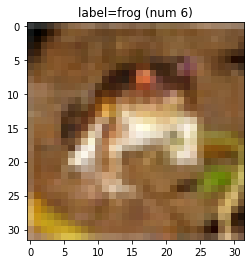

In [2]:
lbl=Y[0]
print("Shape before: ", X[0].shape)
img=X[0].reshape(3,32,32).transpose(1,2,0).astype("int32")  #0 - channels at last, 1 - 32 width first, 2 - 32 height second, total (32,32,3)
print("Shape after: ", img.shape)
plt.title(f"label={label_names[lbl]} (num {lbl})")
plt.imshow(img)

Define Random classifier and accuracy calculation function.

Random classifier will randomly try to guess the classes of the test dataset. Considering we have 10 classes, the random classifier has at best 10% chance of correctly classifying the images. So, anything we build has to be better than 10% baseline to be considered as better.

In [3]:
def class_acc(pred,gt): #This function will compare the Labels that were predicted using any 
                        #classifier (such as Random or 1NN) to Original labels that came with dataset (our ground truth)
                        #and will give us an accuracy estimate of our program.
    err=0            #will store number of mismatches
    accuracy=0          #wil be used to calculate accuracy
    for i in range(0,len(gt)): #Loop to iterate through all ground truth variables and compare with pred.
        if gt[i]!=pred[i]:     #comparing each Pred label to gt label
            err=err+1;         #increment the error counter

    accuracy=(len(pred)-err)/(len(pred)) #calculate the accuracy ((totalpts-error)/totalpts)*100(for %)
    accuracyPercentage=accuracy*100
    return accuracyPercentage

def cifar10_classifier_random(x): #This function will generate random label values from 0 to 9 for the given dataset.
    Rand_labels=np.array([])
    #print("=========== CALLING FUNC. cifar10_classifier_random Random Labels generator ===========")
    
    for i in range(0,len(x)): #Runs a loop from 0 to the length of your dataset
        Rand_label_val=randint(0, 9) #generates a list of random labels for that dataset. 
        Rand_labels = np.append(Rand_labels,Rand_label_val)
        
    #print("Predicted Label's Dimensions: ",Rand_labels.shape) #verify the shape of predicted labels
    return Rand_labels                                      #return predicted variables.


print("accuracy and Random functions Loaded...")

accuracy and Random functions Loaded...


**Random Classifier Accuracy**

In [4]:
Values=cifar10_classifier_random(X)  #Function predicts and returns an array full of Random Labels.
Acc=class_acc(Values,Y) #Function Evaluates the Predicted labels and Actual labels to calculate the Accuracy %.
print("Random Classifier Accuracy for Predicted Labels in %: ",Acc)

Random Classifier Accuracy for Predicted Labels in %:  10.186


KNN function will compare the query each datapoint with each datapoint in our database(X) and find the top K closest matches. Distances are sorted in ascending order and top-K are taken. Then we find the ones that are unique and their frequency. Return the Label which shows the highest frequency of occurance. 

In [5]:

print("KNN Function Loaded...")

KNN Function Loaded...


In [19]:
#used to rearange values that come out of np.unique. 
#np.unique sorts and changes the order of our values in matrix which is undesirable.

def srt(Values):
    if Values.shape[1] > 1:
        Values = Values[Values[:,1].argsort()]
        Values = Values[:, Values[0, :].argsort()]
    else:
        Values = Values[Values[:,0].argsort()]

    return Values



def dist2(x, y, squared=True):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
   
    xx = np.sum(x * x, axis=1, dtype=float)[:, np.newaxis]
    yy = np.sum(y * y, axis=1, dtype=float)

    distances = -2 * np.dot(x, y.T)

    distances += xx
    distances += yy
    
    if squared==True:
        
        return np.sqrt(distances)
    

    return distances


def fast_KNN(Xa,Ya,Qp,K):
    #K=3
    KNN_labels=np.array([])
    dist_values = []

    dist_values = dist2(Qp,Xa, squared=True) #call function to calc. dist b/w Qp array and Xp array datapoints
    #print(dist_values,dist_values.shape)
    #print()

    #Append Labels to all Query Image distances

    Ya2 = np.tile(Ya, (dist_values.shape[0],1))
    #print(Ya2,Ya2.shape)
    #print()

    dist_values = np.stack([dist_values, Ya2]).transpose(1,2,0)
    #print(dist_values,dist_values.shape)
    #print()

    #Get the K Nearest neighbours for each image and fetch their estimated class label

    for i in range(len(dist_values)):  #Process one Query image at a time. loop length = Query array datapoints.

        values3 = sorted(dist_values[i], key = lambda x:x[0])[:K]  #Sort distances
        values3 = np.array(values3)                                #Convert to array
        #print(values3)

        dist_values3 = np.unique(values3[:,1],return_counts=True, return_index=True)  #return the frequencies of labels in K distances. 
        dist_values3 = np.array(dist_values3)                                         #(which class occurs how many times...)
        #print(dist_values3)

        dist_values3 = srt(dist_values3) #call function to rearange the values returned by np.uniique. 
                                         #Order of returned array: R0 - index values; R1 - Frequency of Labels; R2 - Labels.
        #print(dist_values3)

        index=dist_values3[1].argmax()     #Get the index of ones which occurs maximum number of times.
        #print(index)   

        output=dist_values3[2][index]      #Get that class Label value.
        #print(output) 

        KNN_labels = np.append(KNN_labels,output)  #Append to list

    return KNN_labels

print("Fast KNN loaded")


Fast KNN loaded


## Testing the speed of Algo

**Fast KNN**

**Let's run on a smaller batch for multiple K values.**

First, let's create a smaller datasets using traintest split with equal class distributions.

In [7]:
X_small, aa, Y_small, bb = train_test_split(X, Y, test_size=44000, random_state=0, stratify=Y)
print("Small Dataset's Dimensions:" ,X_small.shape,"class Dim: ", Y_small.shape)

Q_TST_small, cc, Q_Label_small, dd = train_test_split(Q_TST, Q_Label, test_size=8000, random_state=0, stratify=Q_Label)
print("Small Test Dataset's Dimensions:" ,Q_TST_small.shape,"class Dim: ", Q_Label_small.shape)


Small Dataset's Dimensions: (6000, 3072) class Dim:  (6000,)
Small Test Dataset's Dimensions: (2000, 3072) class Dim:  (2000,)


In [20]:
%%timeit -r 1 -n 2
k=1
BATCH = fast_KNN(X_small,Y_small,Q_TST_small,k)
BATCH_Acc = class_acc(BATCH,Q_Label_small)
print("K={} Accuracy in %: ".format(k), BATCH_Acc)

K=1 Accuracy in %:  25.0
K=1 Accuracy in %:  25.0
10.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 2 loops each)


### K Nearest Neighbour Classifier

**let's verify their distributions...**

In [10]:
print("Small Training dataset...")
df_Y_Full_New = pd.DataFrame(Y_small)
print(df_Y_Full_New.value_counts(sort=True))
print()
print("Total datapoints" , Y_small.shape[0])
print()
print()
print("Small Test dataset...")
df_Y_Full_New = pd.DataFrame(Q_Label_small)
print(df_Y_Full_New.value_counts(sort=True))
print()
print("Total datapoints" , Q_Label_small.shape[0])

Small Training dataset...
0    600
1    600
2    600
3    600
4    600
5    600
6    600
7    600
8    600
9    600
dtype: int64

Total datapoints 6000


Small Test dataset...
0    200
1    200
2    200
3    200
4    200
5    200
6    200
7    200
8    200
9    200
dtype: int64

Total datapoints 2000


In [22]:
Accuracy_List=[]

for k in range (1,16):
    
    BATCH = fast_KNN(X,Y,Q_TST,k)  #Running on full data
    BATCH_Acc = class_acc(BATCH,Q_Label)
    Accuracy_List.append(BATCH_Acc)
    print("K={} Accuracy in %: ".format(k), BATCH_Acc)

K=1 Accuracy in %:  31.61
K=2 Accuracy in %:  31.790000000000003
K=3 Accuracy in %:  29.29
K=4 Accuracy in %:  27.169999999999998
K=5 Accuracy in %:  25.21
K=6 Accuracy in %:  23.05
K=7 Accuracy in %:  20.68
K=8 Accuracy in %:  19.509999999999998
K=9 Accuracy in %:  16.93
K=10 Accuracy in %:  15.1
K=11 Accuracy in %:  14.04
K=12 Accuracy in %:  13.04
K=13 Accuracy in %:  12.29
K=14 Accuracy in %:  12.09
K=15 Accuracy in %:  11.97


**Plot the accuracy data over Multiple K values**

[31.61, 31.790000000000003, 29.29, 27.169999999999998, 25.21, 23.05, 20.68, 19.509999999999998, 16.93, 15.1, 14.04, 13.04, 12.29, 12.09, 11.97]


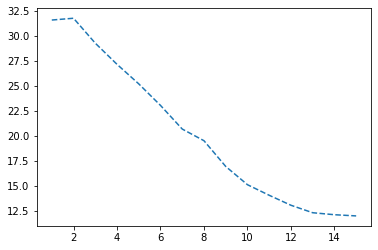

In [23]:
print(Accuracy_List)
K_values = np.arange(1,len(Accuracy_List)+1)
plt.figure()
plt.plot(K_values,Accuracy_List,'--')
plt.show()